## ML Flow Setup

In [1]:
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("fake-job-detector")


<Experiment: artifact_location='mlflow-artifacts:/277809539050116112', creation_time=1758745692533, experiment_id='277809539050116112', last_update_time=1758745692533, lifecycle_stage='active', name='fake-job-detector', tags={'mlflow.experimentKind': 'custom_model_development'}>

## Imports and load

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
raw_path = "../data/raw/fake_job_postings.csv"
proc_dir = "../data/processed"
os.makedirs(proc_dir, exist_ok=True)

# Load raw
df = pd.read_csv(raw_path)
df.head()


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## Basic audit



In [3]:
# Class balance
class_share = df["fraudulent"].value_counts(normalize=True).rename("share").to_frame()
display(class_share)

# Missing values top 15
missing = df.isna().mean().sort_values(ascending=False).head(15).rename("missing_rate")
display(missing)


,share
fraudulent,
0,0.951566
1,0.048434


salary_range           0.839597
department             0.645805
required_education     0.453300
benefits               0.403356
required_experience    0.394295
function               0.361018
industry               0.274217
employment_type        0.194128
company_profile        0.185011
requirements           0.150783
location               0.019351
description            0.000056
title                  0.000000
job_id                 0.000000
telecommuting          0.000000
Name: missing_rate, dtype: float64

## Text length features

In [4]:
text_cols = ["title","company_profile","description","requirements","benefits"]
for c in text_cols:
    if c in df.columns:
        df[f"{c}_len"] = df[c].fillna("").str.split().str.len()

df[text_cols + [f"{c}_len" for c in text_cols if f"{c}_len" in df.columns]].head(3)


,title,company_profile,description,requirements,benefits,title_len,company_profile_len,description_len,requirements_len,benefits_len
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,2,141,124,115,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,6,153,315,200,227
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,4,141,50,164,0


##  Plot helper

In [5]:
def plot_hist(series, bins=50, title="", xlabel=""):
    fig, ax = plt.subplots(figsize=(6,4))
    sns.histplot(series.dropna(), bins=bins, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel or series.name)
    ax.set_ylabel("Count")
    fig.tight_layout()
    return fig


## Log EDA figures to MLflow

🏃 View run eda_v1 at: http://127.0.0.1:5000/#/experiments/277809539050116112/runs/ea9b225dbab54e2c819a45e8bcc12e7b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/277809539050116112


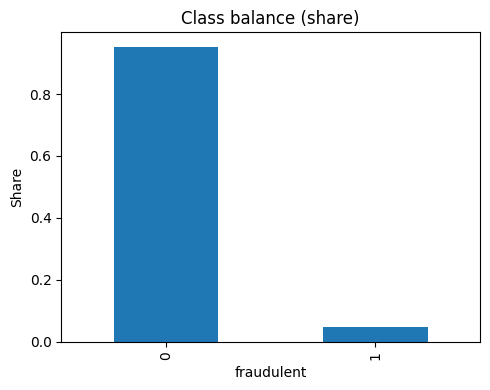

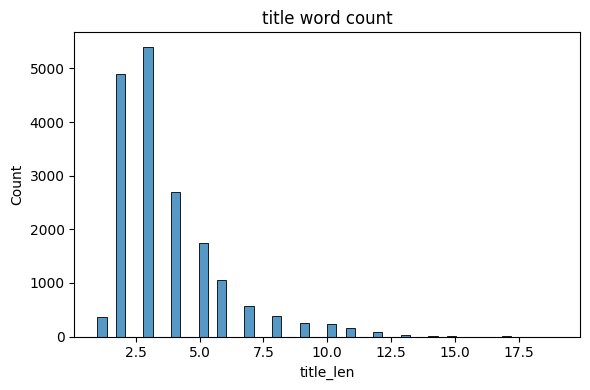

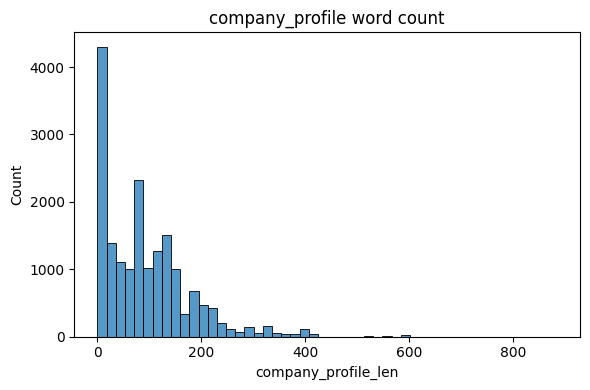

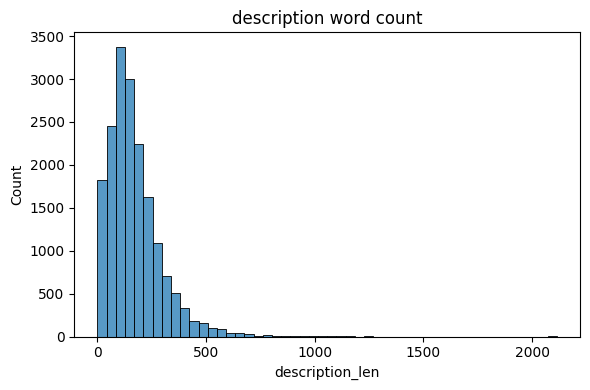

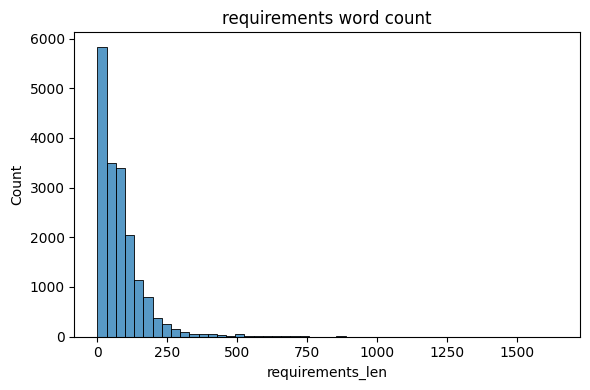

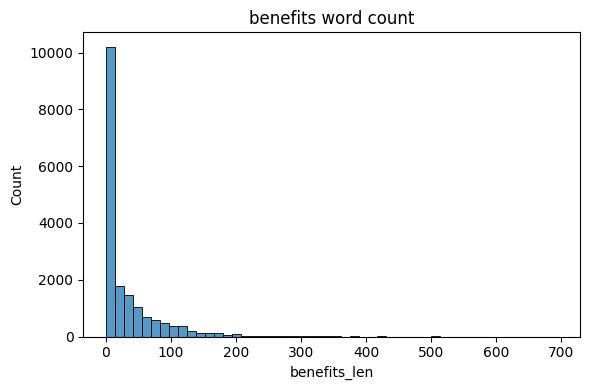

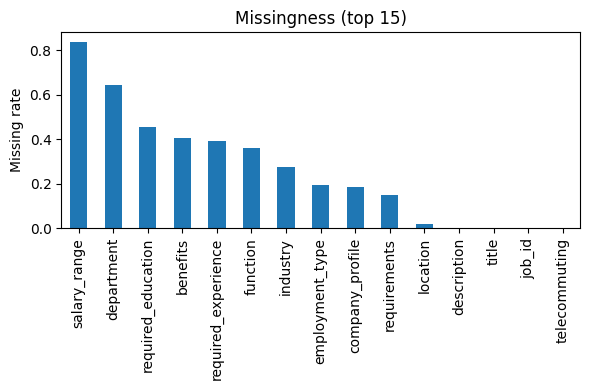

In [6]:
with mlflow.start_run(run_name="eda_v1"):
    # Class balance bar
    fig_cb, ax = plt.subplots(figsize=(5,4))
    class_share["share"].plot(kind="bar", ax=ax, title="Class balance (share)")
    ax.set_ylabel("Share")
    fig_cb.tight_layout()
    mlflow.log_figure(fig_cb, "eda/class_balance.png")

    # Length histograms
    for c in text_cols:
        len_col = f"{c}_len"
        if len_col in df.columns:
            fig = plot_hist(df[len_col], bins=50, title=f"{c} word count", xlabel=len_col)
            mlflow.log_figure(fig, f"eda/{len_col}_hist.png")

    # Missingness bar (top 15)
    fig_m, ax = plt.subplots(figsize=(6,4))
    missing.sort_values(ascending=False).plot(kind="bar", ax=ax, title="Missingness (top 15)")
    ax.set_ylabel("Missing rate")
    fig_m.tight_layout()
    mlflow.log_figure(fig_m, "eda/missing_top15.png")


1. All fields show right‑skewed, long‑tailed length distributions, so most posts are short-to-moderate with a small set of very long outliers to cap or clip at high percentiles.
</br>
2. Relative lengths are consistent: titles are the shortest, descriptions the longest, with requirements and company profiles in between; plan features and max token limits accordingly.
</br>
3. Benefits text is often empty or very short; add a binary “has_benefits” feature alongside its text to capture informative absence/presence signal.
</br>
4. Short fields (titles, many requirements) benefit from n‑grams and simple pattern counts (URLs, emails, numbers), while long fields need TF‑IDF caps and normalization to avoid dominance by a few lengthy posts.
</br>
5. Check per‑label length differences and deduplicate boilerplate company/benefits text to prevent leakage; log these choices in the EDA so modeling decisions are reproducible.

## Build df_proc and concatenate text

In [7]:
def concat_text(df_):
    cols = ["title","company_profile","description","requirements","benefits"]
    return sum([df_[c].fillna("") + " " for c in cols[0:4]], df_[cols[4]].fillna(""))

df_proc = df.copy()
df_proc["text_all"] = concat_text(df_proc)
df_proc.head(2)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,required_education,industry,function,fraudulent,title_len,company_profile_len,description_len,requirements_len,benefits_len,text_all
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,...,NaN,NaN,Marketing,0,2,141,124,115,0,"Marketing Intern We're Food52, and we've creat..."
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,...,NaN,Marketing and Advertising,Customer Service,0,6,153,315,200,227,What you will get from usThrough being part of...


## Train/valid/test split (stratified 70/15/15)

In [8]:
from sklearn.model_selection import train_test_split

SEED = 42
train_df, temp_df = train_test_split(
    df_proc, test_size=0.30, random_state=SEED, stratify=df_proc["fraudulent"]
)
valid_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=SEED, stratify=temp_df["fraudulent"]
)

print("Overall share:", df["fraudulent"].mean())
print("Train share:  ", train_df["fraudulent"].mean())
print("Valid share:  ", valid_df["fraudulent"].mean())
print("Test share:   ", test_df["fraudulent"].mean())


Overall share: 0.04843400447427293
Train share:   0.048418024928092045
Valid share:   0.048471290082028336
Test share:    0.048471290082028336


## Log split metadata to MLflow

In [9]:
with mlflow.start_run(run_name="splits_v1"):
    mlflow.log_dict(
      {"split": {"train": int(len(train_df)), "valid": int(len(valid_df)), "test": int(len(test_df)), "seed": SEED}},
      "eda/splits.json"
    )
    mlflow.log_text(
      "Stratified 70/15/15; fillna('') per text field; concat order title + company_profile + description + requirements + benefits.",
      "eda/data_card.md"
    )


🏃 View run splits_v1 at: http://127.0.0.1:5000/#/experiments/277809539050116112/runs/1c696d805548407ba3f743887b74c6ef
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/277809539050116112
